# AI project: Medical Image Segmentation using U-Net architecture

The goal of this project is to develop a segmentation model for liver medical images. Segmenting organs in CT images is crucial for various medical applications, including assisting in diagnostics, planning surgical interventions, and tracking treatment progress. Specifically, segmenting the liver allows for better tumor localization, liver volume estimation, and disease monitoring. The challenge lies in the variability of liver shapes and textures depending on patients and pathological conditions.

## 1. Necessary imports

In [ ]:
# Import essential libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Metric imports
from sklearn.metrics import jaccard_score, accuracy_score


## 2. U-Net Architecture

The U-Net is a convolutional neural network designed for image segmentation. It consists of a contracting path to capture features, a bottleneck for deep representations, and an expanding path with skip connections to recover spatial details. This architecture is widely used for tasks requiring precise pixel-level predictions.

In [ ]:
# A pair of convolutional layers
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


# Main U-net model
class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        # Contracting path
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom layer
        self.conv5 = DoubleConv(512, 1024)

        # Expanding path
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # Output layer
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)

        c5=self.conv5(p4)

        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)

        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)

        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)

        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)

        c10=self.conv10(c9)

        return c10

## 3. Data preprocessing

In [ ]:
# Path to dataset
data_dir = "./Liver_Medical_Image_Datasets"
image_dir = os.path.join(data_dir, "Images")
label_dir = os.path.join(data_dir, "Labels")

# Define dataset class for training data
class LiverDataset(Dataset):
    def __init__(self, images, labels, image_transform=None, mask_transform=None):
        self.images = images
        self.labels = labels
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(label_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

    def get_original_image(self, idx):
        return Image.open(self.images[idx]).convert("RGB")

# Get image and label paths
images = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
labels = sorted([os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir)])

# Randomly shuffle and split data for training and validation
data = list(zip(images, labels))
random.shuffle(data)
split_idx = int(0.9 * len(data))
train_data, val_data = data[:split_idx], data[split_idx:]

# Define transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
mask_transform = transforms.ToTensor()

# Initialize datasets and loaders
train_dataset = LiverDataset([x[0] for x in train_data], [x[1] for x in train_data],
                             image_transform=image_transform, mask_transform=mask_transform)
val_dataset = LiverDataset([x[0] for x in val_data], [x[1] for x in val_data],
                           image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Training the model

Epoch [1/20], Batch [15/45], Loss: 0.2777
Epoch [1/20], Batch [30/45], Loss: 0.1955
Epoch [1/20], Batch [45/45], Loss: 0.1422
Epoch [1/20], Train Loss: 0.2593, Validation Loss: 0.2068
Epoch [2/20], Batch [15/45], Loss: 0.1227
Epoch [2/20], Batch [30/45], Loss: 0.1110
Epoch [2/20], Batch [45/45], Loss: 0.0773
Epoch [2/20], Train Loss: 0.1086, Validation Loss: 0.0926
Epoch [3/20], Batch [15/45], Loss: 0.0619
Epoch [3/20], Batch [30/45], Loss: 0.0547
Epoch [3/20], Batch [45/45], Loss: 0.0570
Epoch [3/20], Train Loss: 0.0609, Validation Loss: 0.0465
Epoch [4/20], Batch [15/45], Loss: 0.0412
Epoch [4/20], Batch [30/45], Loss: 0.0570
Epoch [4/20], Batch [45/45], Loss: 0.0342
Epoch [4/20], Train Loss: 0.0431, Validation Loss: 0.0324
Epoch [5/20], Batch [15/45], Loss: 0.0287
Epoch [5/20], Batch [30/45], Loss: 0.0294
Epoch [5/20], Batch [45/45], Loss: 0.0252
Epoch [5/20], Train Loss: 0.0313, Validation Loss: 0.0345
Epoch [6/20], Batch [15/45], Loss: 0.0268
Epoch [6/20], Batch [30/45], Loss: 0.0

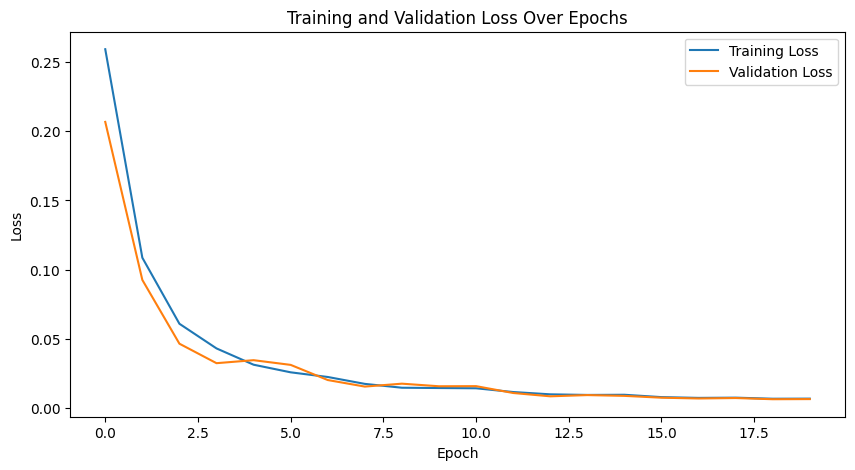

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_ch=3, out_ch=1).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary segmentation
optimizer = optim.Adam(model.parameters())

# Validation function to compute the loss on the validation dataset
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(val_loader)

num_epochs = 20
train_losses = []
val_losses = []

# Training loop with batch-wise loss print
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # Track the loss for the entire epoch

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass and optimization
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Add batch loss to epoch loss
        epoch_loss += loss.item()

        # Print batch loss
        if (batch_idx + 1) % 15 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Validation loss
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")


# Save the trained model
torch.save(model.state_dict(), "./unet_model.pth")

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()


## 5. Results of the training

<ipython-input-8-34d17c79a4c3>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


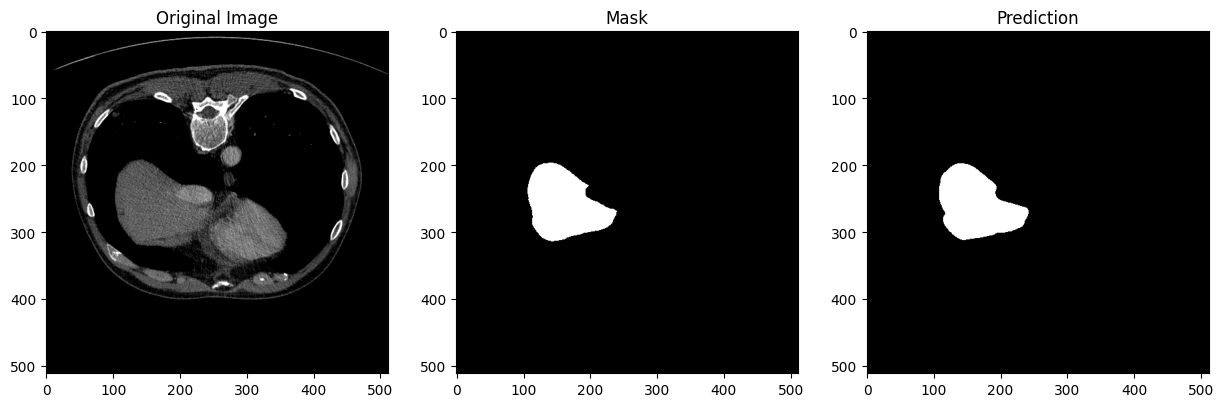

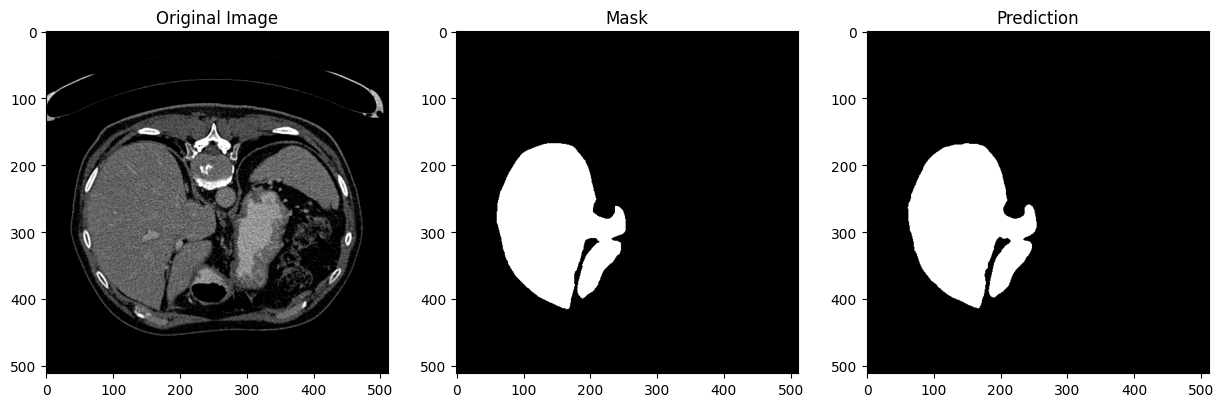

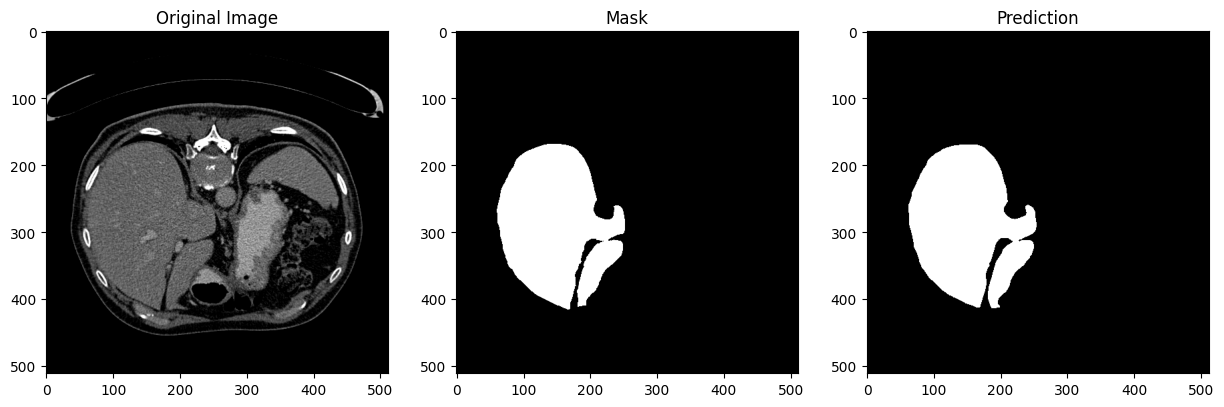

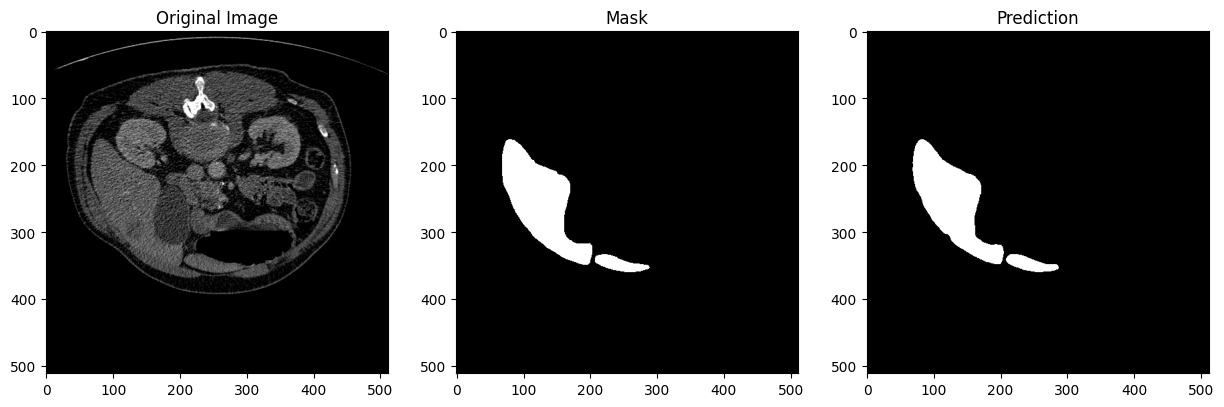

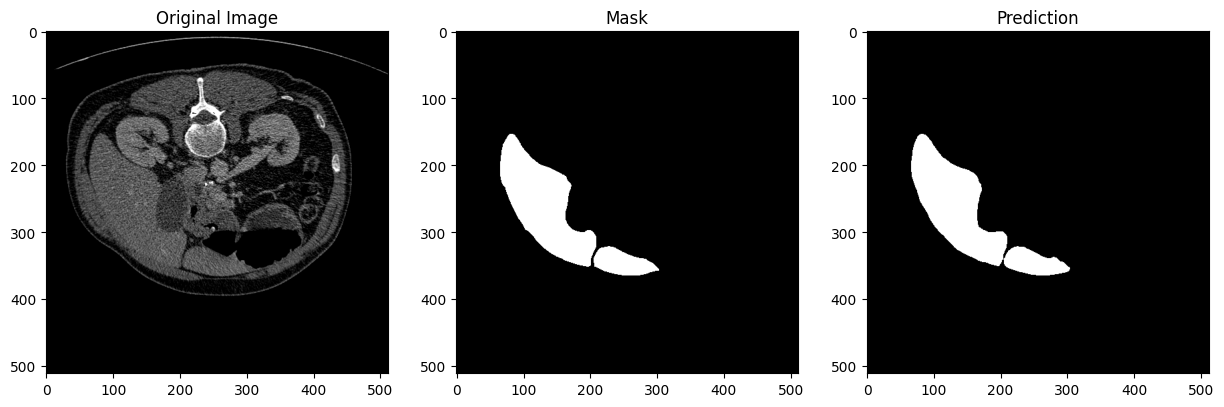

Mean IoU (mIoU): 0.9659
Mean Pixel Accuracy (mPA): 0.9976


In [ ]:
# Function to evaluate mIoU and mPA
def evaluate_metrics(preds, labels):
    # Threshold predictions and flatten
    preds = (preds > 0.5).float().cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()

    # mIoU
    mIoU = jaccard_score(labels, preds)

    # mPA
    mPA = accuracy_score(labels, preds)

    return mIoU, mPA

# Loading the model
model = Unet(in_ch=3, out_ch=1).to(device)
model_path = "./unet_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Validation loop
model.eval()
miou_total = 0
mpa_total = 0
with torch.no_grad():
    for idx, (images, masks) in enumerate(val_loader):
        images, masks = images.to(device), masks.to(device)

        # Get prediction
        outputs = model(images)
        preds = (outputs > 0.5).float()

        # Calculate metrics
        miou, mpa = evaluate_metrics(preds, masks)
        miou_total += miou
        mpa_total += mpa

        # Display original image, mask, and prediction
        if idx < 5:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            original_image = val_dataset.get_original_image(idx)
            ax[0].imshow(original_image)
            ax[0].set_title("Original Image")
            ax[1].imshow(masks[0].cpu().squeeze(), cmap="gray")
            ax[1].set_title("Mask")
            ax[2].imshow(preds[0].cpu().squeeze(), cmap="gray")
            ax[2].set_title("Prediction")
            plt.show()

# Calculate average mIoU and mPA for the dataset
miou_avg = miou_total / len(val_loader)
mpa_avg = mpa_total / len(val_loader)
print(f"Mean IoU (mIoU): {miou_avg:.4f}")
print(f"Mean Pixel Accuracy (mPA): {mpa_avg:.4f}")


The U-Net model successfully segmented the liver region with high precision, closely matching the ground truth mask.
The evaluation metrics further validate the model's effectiveness. The average mIoU of 0.9659 showcases the model's ability to accurately delineate liver regions, with a high overlap between the predicted and true masks. Meanwhile, the average mPA of 0.9976 reflects near-perfect pixel classification, indicating the model's precision in distinguishing liver tissues from the background. Together, these results highlight the U-Net model’s robustness and reliability for medical image segmentation tasks.
